Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    1690 non-null   object 
 1   X-Acceleration          1690 non-null   float64
 2   Y-Acceleration          1690 non-null   float64
 3   Z-Acceleration          1690 non-null   float64
 4   X-Velocity              1690 non-null   float64
 5   Y-Velocity              1690 non-null   float64
 6   Z-Velocity              1690 non-null   float64
 7   Composite-Acceleration  1690 non-null   float64
 8   Composite-Velocity      1690 non-null   float64
 9   Temperature Z           1690 non-null   float64
 10  Temperature-XYZ         1690 non-null   float64
dtypes: float64(10), object(1)
memory usage: 145.4+ KB
None

Thống kê mô tả dữ liệu:
       X-Acceleration  Y-Acceleration  Z-Acceleration   X-Velocity  \
count     1690.000000     1690

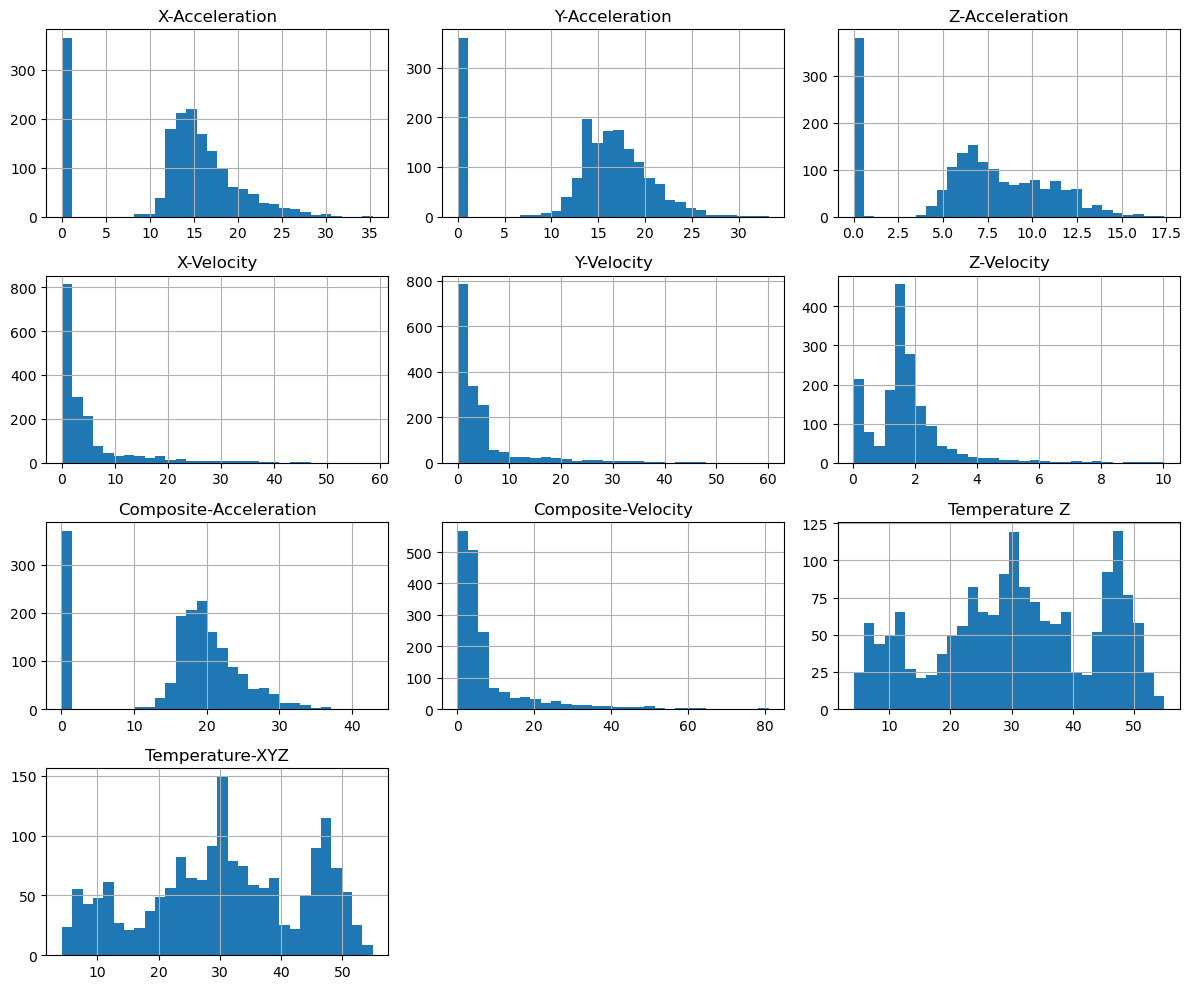

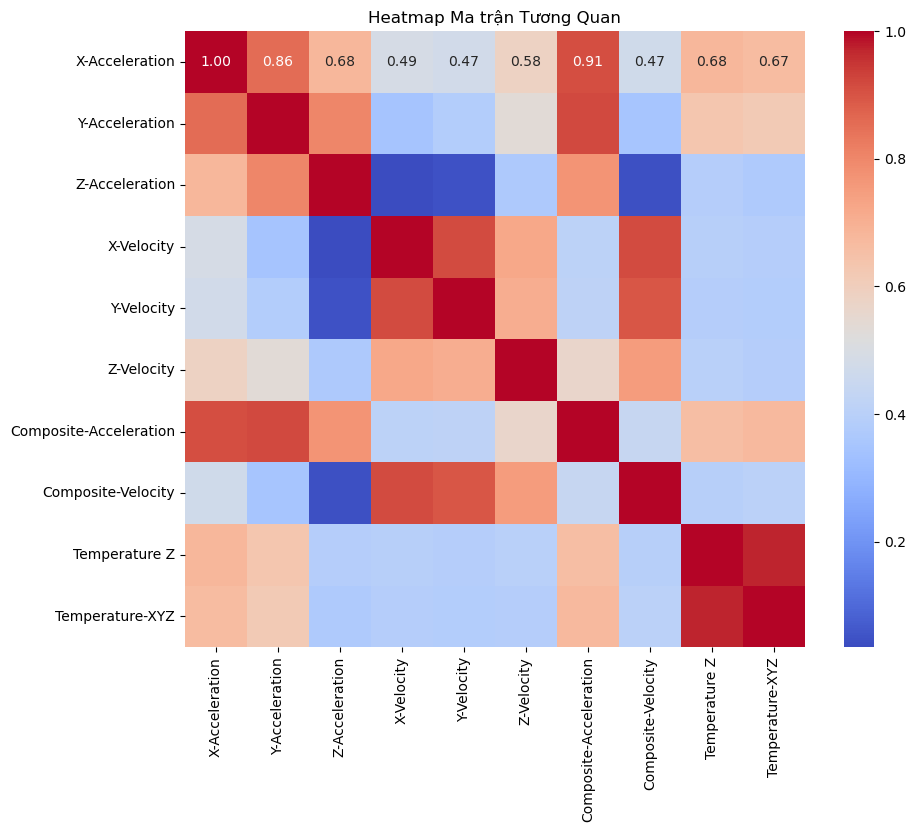


Số lượng giá trị bị thiếu trên từng cột:
Time                      0
X-Acceleration            0
Y-Acceleration            0
Z-Acceleration            0
X-Velocity                0
Y-Velocity                0
Z-Velocity                0
Composite-Acceleration    0
Composite-Velocity        0
Temperature Z             0
Temperature-XYZ           0
dtype: int64


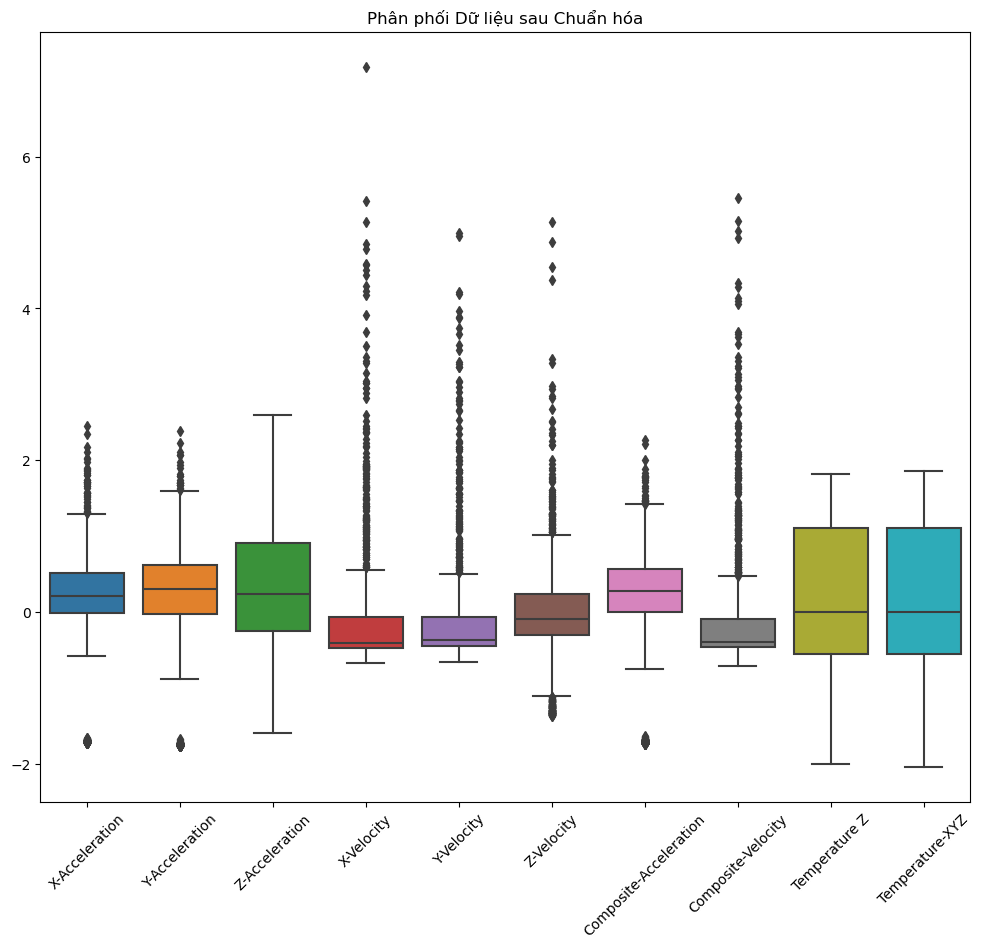

Epoch 1/50, Loss: 0.0884
Epoch 2/50, Loss: 0.0389
Epoch 3/50, Loss: 0.0312
Epoch 4/50, Loss: 0.0290
Epoch 5/50, Loss: 0.0275
Epoch 6/50, Loss: 0.0273
Epoch 7/50, Loss: 0.0262
Epoch 8/50, Loss: 0.0257
Epoch 9/50, Loss: 0.0251
Epoch 10/50, Loss: 0.0250
Epoch 11/50, Loss: 0.0248
Epoch 12/50, Loss: 0.0246
Epoch 13/50, Loss: 0.0246
Epoch 14/50, Loss: 0.0244
Epoch 15/50, Loss: 0.0242
Epoch 16/50, Loss: 0.0240
Epoch 17/50, Loss: 0.0240
Epoch 18/50, Loss: 0.0244
Epoch 19/50, Loss: 0.0239
Epoch 20/50, Loss: 0.0241
Epoch 21/50, Loss: 0.0245
Epoch 22/50, Loss: 0.0240
Epoch 23/50, Loss: 0.0248
Epoch 24/50, Loss: 0.0238
Epoch 25/50, Loss: 0.0238
Epoch 26/50, Loss: 0.0238
Epoch 27/50, Loss: 0.0238
Epoch 28/50, Loss: 0.0238
Epoch 29/50, Loss: 0.0236
Epoch 30/50, Loss: 0.0240
Epoch 31/50, Loss: 0.0239
Epoch 32/50, Loss: 0.0238
Epoch 33/50, Loss: 0.0238
Epoch 34/50, Loss: 0.0236
Epoch 35/50, Loss: 0.0238
Epoch 36/50, Loss: 0.0238
Epoch 37/50, Loss: 0.0237
Epoch 38/50, Loss: 0.0237
Epoch 39/50, Loss: 0.

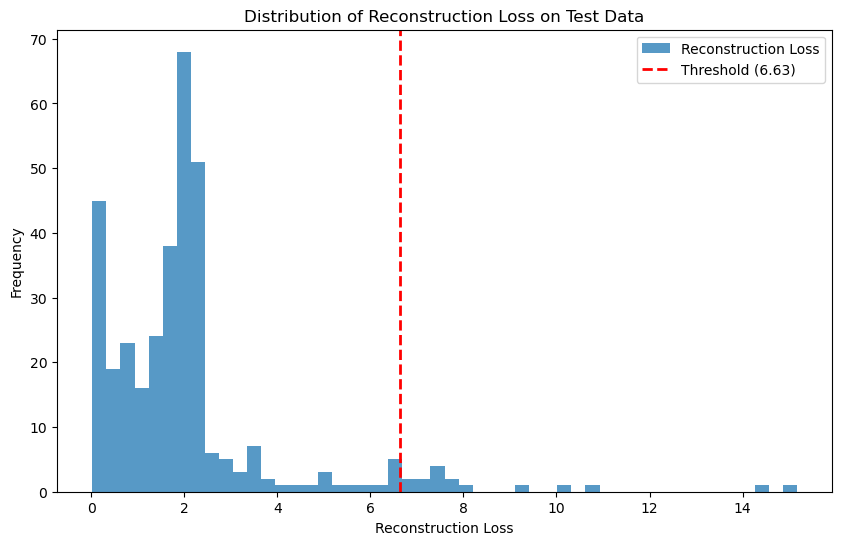

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Đọc dữ liệu từ file CSV
data = pd.read_csv('../../data/Chiller.csv')

# In thông tin tổng quan về dữ liệu
print("Thông tin dữ liệu:")
print(data.info())

print("\nThống kê mô tả dữ liệu:")
print(data.describe())

# 2. EDA - Phân tích dữ liệu
# 2.1. Kiểm tra phân phối dữ liệu
print("\nPhân phối dữ liệu trên từng cột:")
data.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

# 2.2. Phân tích tương quan giữa các cột
# Chỉ giữ lại các cột số
numeric_data = data.select_dtypes(include=[np.number])

# Tính ma trận tương quan
correlation_matrix = numeric_data.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Ma trận Tương Quan")
plt.show()

# 2.3. Kiểm tra dữ liệu bị thiếu
missing_data = data.isnull().sum()
print("\nSố lượng giá trị bị thiếu trên từng cột:")
print(missing_data)

# 3. Chọn các cột đặc trưng (bỏ qua các cột không cần thiết)
features = data.drop(columns=['Time'], errors='ignore')  # Bỏ cột 'Time' nếu có

# 4. Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 5. Tách dữ liệu thành tập huấn luyện và kiểm tra (80% train, 20% test)
train_size = int(0.8 * len(scaled_features))
X_train = scaled_features[:train_size]
X_test = scaled_features[train_size:]

# 6. EDA - Trực quan hóa phân phối các đặc trưng sau chuẩn hóa
scaled_df = pd.DataFrame(X_train, columns=features.columns)
plt.figure(figsize=(12, 10))
sns.boxplot(data=scaled_df)
plt.title("Phân phối Dữ liệu sau Chuẩn hóa")
plt.xticks(rotation=45)
plt.show()

# 7. Chuyển đổi dữ liệu thành Tensor cho PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 8. Định nghĩa mô hình VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=-1)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decoder(z)
        return x_hat, mean, logvar

# 9. Khởi tạo mô hình, optimizer và loss
input_dim = X_train.shape[1]
latent_dim = 2
model = VAE(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 10. Huấn luyện mô hình VAE
epochs = 50
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(epochs):
    total_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_hat, mean, logvar = model(x)
        recon_loss = nn.MSELoss()(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}")

# 11. Dự đoán trên tập kiểm tra
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test_tensor)
    reconstruction_loss = torch.mean((X_test_tensor - X_test_pred) ** 2, dim=1).numpy()

# 12. Thiết lập ngưỡng phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 95)  # Ngưỡng 95%
anomalies = (reconstruction_loss > threshold).astype(int)  # Đánh dấu bất thường nếu lỗi tái tạo lớn hơn ngưỡng

# 13. In ra số lượng điểm bất thường
num_anomalies = np.sum(anomalies)
print(f"Số lượng điểm bất thường phát hiện: {num_anomalies}")

# 14. Vẽ biểu đồ phân phối lỗi tái tạo
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50, alpha=0.75, label='Reconstruction Loss')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Loss on Test Data')
plt.legend()
plt.show()
